In [48]:
import torch
import numpy as np
import random
import datetime

import sys
sys.path.append('../../quantization_utils')

from _Loading_All_Model import *
from _Loading_All_Dataloader import * 
from quantization import *

quantized_bit = 8
target_dataset = "NMNIST"
batch_size = 64
dataset_path = '/home/edwin/code/dataset/'
num_images = 1024

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Loading Weights: ")
weight_path = '../../pretrained_weights_float32/pre_trained_normal-nmnist_snn_300e.t7'
model = NMNIST_model(T_BIN=15).to(device)
checkpoint = torch.load(weight_path,map_location=device)
model.load_state_dict(checkpoint['net'])
quantize_weights_nbits(model,quantized_bit)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"total trainable parameters: {num_params/2**20:.3f}M")
print(f"This is a {quantized_bit}-bit quantized model: {num_params*quantized_bit/2**20:.3f}M bits")

# Dataset (TEST and Subset Loader)
_ , test_loader = choose_dataset(target=target_dataset,batch_size=batch_size,T_BIN=15,dataset_path=dataset_path)
UNTARGETED_loader = UNTARGETED_loader(target=target_dataset,num_images=num_images,batch_size=batch_size,T_BIN=15,dataset_path =dataset_path)


Loading Weights: 
The current layer is: fc1: 
finished quantized fc1 weights to 8 BITs
The current layer is: fc2: 
finished quantized fc2 weights to 8 BITs
total trainable parameters: 1.134M
This is a 8-bit quantized model: 9.070M bits


In [43]:
import torch
import numpy as np
import random
import datetime

import sys
sys.path.append('../../quantization_utils')

from _Loading_All_Model import *
from _Loading_All_Dataloader import * 
from quantization import *

quantized_bit = 8
target_dataset = "DVS128_Gesture"
batch_size = 1
dataset_path = '/home/edwin/code/dataset/'
num_images = 1

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Loading Weights: ")
weight_path = '../../pretrained_weights_float32/fine_tuning_attack_DVS128_Gesture.t7'
model = DVS128_model(T_BIN=60).to(device)
checkpoint = torch.load(weight_path,map_location=device)
model.load_state_dict(checkpoint['net'])
quantize_weights_nbits(model,quantized_bit)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"total trainable parameters: {num_params/2**20:.3f}M")
print(f"This is a {quantized_bit}-bit quantized model: {num_params*quantized_bit/2**20:.3f}M bits")

# Dataset (TEST and Subset Loader)
_ , test_loader = choose_dataset(target=target_dataset,batch_size=batch_size,T_BIN=60,dataset_path=dataset_path)
UNTARGETED_loader = UNTARGETED_loader(target=target_dataset,num_images=num_images,batch_size=batch_size,T_BIN=60,dataset_path =dataset_path)


Loading Weights: 
The current layer is: conv0: 
finished quantized conv0 weights to 8 BITs
The current layer is: conv1: 
finished quantized conv1 weights to 8 BITs
The current layer is: conv2: 
finished quantized conv2 weights to 8 BITs
The current layer is: conv3: 
finished quantized conv3 weights to 8 BITs
The current layer is: fc1: 
finished quantized fc1 weights to 8 BITs
The current layer is: fc2: 
finished quantized fc2 weights to 8 BITs
total trainable parameters: 4.504M
This is a 8-bit quantized model: 36.032M bits


In [9]:
print(f"Before Attacking: {check_accuracy(test_loader,model,attack=True)*100}% Accuracy")
start = datetime.datetime.now()
print(datetime.datetime.now())

Checking on testing data
Got 235/264 with accuracy 89.02
Before Attacking: 89.0151596069336% Accuracy
2024-04-20 03:30:28.595762


In [44]:
from pgd import PGD #25
atk = PGD(model, eps=0.08, steps=25)

#### If targeted attack ####
atk.set_mode_targeted_random()
###############################

print(atk)

Attack mode is changed to 'targeted(random)'.
PGD(model_name=DVS128_model, device=cuda:0, attack_mode=targeted(random), targeted=True, normalization_used=False, eps=0.08, steps=25)


In [45]:
correct = 0
total = 0
median_perturb = 0
model.eval()
for _, (inputs, targets) in enumerate(UNTARGETED_loader):
    # print(inputs.shape)
    # print(inputs.transpose(0,1)[0].shape)
    # for i in range(1000):
    #     print("origin")
    #     print(inputs.transpose(0,1)[8][1].flatten()[i])
    #     print("afterwards")
    #     binary_tensor = torch.where(inputs > 0, torch.tensor(1.), torch.tensor(0.))
    #     print(binary_tensor.transpose(0,1)[8][1].flatten()[i])
    # break
    inputs = torch.where(inputs > 0, torch.tensor(1.), torch.tensor(0.))
    inputs = inputs.to(device)
    atk.set_model_training_mode(model_training=False, batchnorm_training=False, dropout_training=False)
    adv_inputs = atk(inputs, targets.to(device))
    with torch.no_grad():
        outputs = model(adv_inputs)
    _, predicted = outputs.cpu().max(1)
    total += float(targets.size(0))
    correct += float(predicted.eq(targets).sum().item())
    # break
final_acc = 100 * correct / total


targeted success


In [46]:
print(final_acc)

0.0


In [47]:
adv_img = adv_inputs.transpose(0,1)[0]
delta = adv_inputs.transpose(0,1)[0] - inputs.transpose(0,1)[0]
print(adv_img.shape)

torch.Size([60, 2, 32, 32])


In [48]:
delta.sum()

tensor(3077., device='cuda:0')

torch.Size([4, 32, 32])
torch.Size([4, 32, 32])
torch.Size([4, 32, 32])
torch.Size([4, 32, 32])


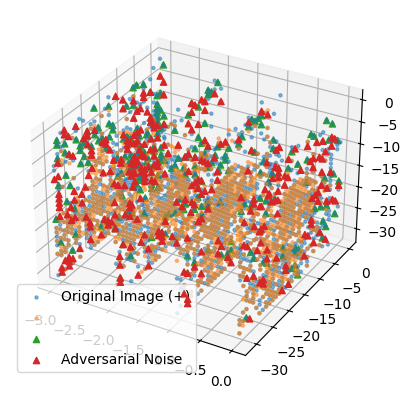

In [49]:
import matplotlib.pyplot as plt

a = adv_img.to('cpu')
# set T=50, first 4 frame
matrix = a.transpose(0,1)[0][0:4]
print(matrix.shape)
indices = np.where(matrix >= 1)

# Extract x-axis and y-axis index arrays
x_indices = -indices[0]
y_indices = -(matrix.shape[2] - 1 - indices[2])
z_indices = -indices[1]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_indices, y_indices, z_indices,marker='.', alpha=0.5, label="Original Image (+)")

matrix = a.transpose(0,1)[1][0:4]
print(matrix.shape)
indices = np.where(matrix >= 1)

# Extract x-axis and y-axis index arrays
x_indices = -indices[0]
y_indices = -(matrix.shape[2] - 1 - indices[2])
z_indices = -indices[1]

ax.scatter(x_indices, y_indices, z_indices, marker='.',alpha=0.5, label=" ")

a = delta.to('cpu')
# set T=50, first 4 frame
matrix = a.transpose(0,1)[0][0:4]
print(matrix.shape)
indices = np.where(matrix >= 1)

# Extract x-axis and y-axis index arrays
x_indices = -indices[0]
y_indices = -(matrix.shape[2] - 1 - indices[2])
z_indices = -indices[1]

ax.scatter(x_indices, y_indices, z_indices,marker='^', alpha=1, label=" ")

matrix = a.transpose(0,1)[1][0:4]
print(matrix.shape)
indices = np.where(matrix >= 1)

# Extract x-axis and y-axis index arrays
x_indices = -indices[0]
y_indices = -(matrix.shape[2] - 1 - indices[2])
z_indices = -indices[1]

ax.scatter(x_indices, y_indices, z_indices, marker='^',alpha=1, label="Adversarial Noise")


# Set labels and title
# ax.set_xlabel('Time')
# ax.set_ylabel('H')
# ax.set_zlabel('W')
# ax.set_title('3D Scatter Plot')
ax.legend()

In [55]:
from _Loading_All_Model import *
from _Loading_All_Dataloader import * 
from quantization import *

# My parameters
epsil = 0.08
N = 32

quantized_bit = 8
target_dataset = "DVS128_Gesture"
dataset_path = '/home/edwin/code/dataset/'
num_images = 1
batch_size = 1
num_classes =11

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
attack_loader = UNTARGETED_loader(target=target_dataset,num_images=num_images,
                                  batch_size=batch_size, T_BIN=60,dataset_path=dataset_path)
x,y = 0,2
left = 1
targeted = False


# Create a corner controlled by x and y, (top left or top right)
def cornerGen(x, y, left=False, N=32, T=60):
  corner = torch.zeros((N,N,T))
  for i in range(N):
    for j in range(N):
      if left:
        if (i==x and j<y):
          corner[i,j,:]=1
      else:
        if (i==x and j>=N-y-1):
          corner[i,j,:]=1         
  return corner.expand(2,N,N,T)

correct = 0
total = 0
for _, (inputs, targets) in enumerate(test_loader):
    inputs = torch.where(inputs > 0, torch.tensor(1.), torch.tensor(0.))
    adv = inputs.clone().detach().permute(1,2,3,4,0).squeeze(dim=0) # TNCHW -> 1 x CHWT -> CHWT
    perturbation =  (adv.unsqueeze(0).permute(4,0,1,2,3) - inputs).view(-1)
    l2_perturbation = torch.norm(perturbation, p=2)/len(perturbation)
    total+=1
    print("original label: ")
    print(targets)
    if targeted:
        non_target_labels = torch.randint(low=0, high=num_classes, size=(batch_size,))
        while non_target_labels.to('cpu') == targets.to('cpu'):
            non_target_labels = torch.randint(low=0, high=num_classes, size=(batch_size,))
        targets = non_target_labels
    print("target label: ")
    print(targets)
    while x<N and y<N and l2_perturbation <= epsil:
        corner= cornerGen(x,y,left) # shape: C, H, W, T
        adv = adv + corner
        with torch.no_grad():
            adv_img = adv.unsqueeze(0).permute(4,0,1,2,3).to(device)
            targets = targets.to(device) 
            output = model(adv_img)

        if targeted:
           if torch.equal(torch.argmax(output, dim=1), targets):
                print("Attack success")
                break
        else:
            if torch.not_equal(torch.argmax(output, dim=1), targets):
                print("Attack success")
                break

        if x==0: # flag = 1, change x to left corner
            x= N-1
        else: # flag = 0, change x to right corner
            left^=1
            x=0
            if not left:
                y+=1
        perturbation =  (adv.unsqueeze(0).permute(4,0,1,2,3) - inputs).view(-1)
        l2_perturbation = torch.norm(perturbation, p=2)/len(perturbation)
        print(l2_perturbation)
    
    x,y = 0,2
    correct+=1    

final_acc = 100 * correct / total

original label: 
tensor([6])
target label: 
tensor([6])
tensor(0.0001)
tensor(0.0002)
tensor(0.0003)
tensor(0.0003)
tensor(0.0004)
tensor(0.0005)
tensor(0.0006)
tensor(0.0006)
tensor(0.0007)
tensor(0.0008)
tensor(0.0009)
tensor(0.0010)
tensor(0.0011)
tensor(0.0012)
tensor(0.0013)
tensor(0.0014)
tensor(0.0015)
tensor(0.0016)
tensor(0.0017)
tensor(0.0018)
tensor(0.0019)
tensor(0.0020)
tensor(0.0022)
tensor(0.0023)
tensor(0.0024)
tensor(0.0025)
tensor(0.0026)
tensor(0.0028)
tensor(0.0029)
tensor(0.0030)
tensor(0.0031)
tensor(0.0032)
tensor(0.0034)
tensor(0.0035)
tensor(0.0036)
tensor(0.0038)
tensor(0.0039)
tensor(0.0040)
tensor(0.0042)
tensor(0.0043)
tensor(0.0044)
tensor(0.0046)
tensor(0.0047)
tensor(0.0049)
tensor(0.0050)
tensor(0.0051)
tensor(0.0053)
tensor(0.0055)
tensor(0.0056)
tensor(0.0057)
tensor(0.0059)
tensor(0.0061)
tensor(0.0062)
tensor(0.0064)
tensor(0.0065)
tensor(0.0067)
tensor(0.0068)
tensor(0.0070)
tensor(0.0072)
tensor(0.0073)
tensor(0.0075)
tensor(0.0077)
tensor(0.0078)

In [57]:
final_acc

100.0

In [37]:
adv_img = adv.unsqueeze(0).permute(4,0,1,2,3)
delta = (adv.unsqueeze(0).permute(4,0,1,2,3) - inputs)
delta.sum().item()

244800.0

In [38]:
print(adv_img.shape)

torch.Size([60, 1, 2, 32, 32])


torch.Size([4, 32, 32])
torch.Size([4, 32, 32])
torch.Size([4, 32, 32])
torch.Size([4, 32, 32])


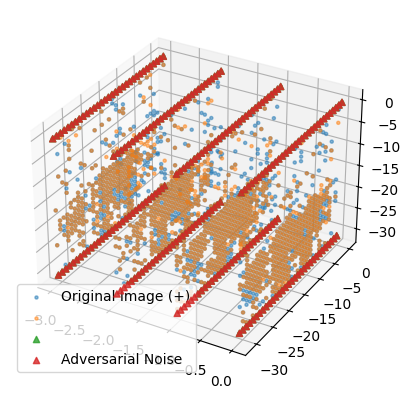

In [39]:
import matplotlib.pyplot as plt

a = adv_img.to('cpu')
# set T=50, first 4 frame
matrix = a.squeeze(1).transpose(0,1)[0][0:4]
print(matrix.shape)
indices = np.where(matrix >= 1)

# Extract x-axis and y-axis index arrays
x_indices = -indices[0]
y_indices = -(matrix.shape[2] - 1 - indices[2])
z_indices = -indices[1]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_indices, y_indices, z_indices,marker='.', alpha=0.5, label="Original Image (+)")

matrix = a.squeeze(1).transpose(0,1)[1][0:4]
print(matrix.shape)
indices = np.where(matrix >= 1)

# Extract x-axis and y-axis index arrays
x_indices = -indices[0]
y_indices = -(matrix.shape[2] - 1 - indices[2])
z_indices = -indices[1]

ax.scatter(x_indices, y_indices, z_indices, marker='.',alpha=0.5, label=" ")

a = delta.to('cpu')
# set T=50, first 4 frame
matrix = a.squeeze(1).transpose(0,1)[0][0:4]
print(matrix.shape)
indices = np.where(matrix >= 1)

# Extract x-axis and y-axis index arrays
x_indices = -indices[0]
y_indices = -(matrix.shape[2] - 1 - indices[2])
z_indices = -indices[1]

ax.scatter(x_indices, y_indices, z_indices,marker='^', alpha=0.8, label=" ")

matrix = a.squeeze(1).transpose(0,1)[1][0:4]
print(matrix.shape)
indices = np.where(matrix >= 1)

# Extract x-axis and y-axis index arrays
x_indices = -indices[0]
y_indices = -(matrix.shape[2] - 1 - indices[2])
z_indices = -indices[1]

ax.scatter(x_indices, y_indices, z_indices, marker='^',alpha=0.8, label="Adversarial Noise")


# Set labels and title
# ax.set_xlabel('Time')
# ax.set_ylabel('H')
# ax.set_zlabel('W')
# ax.set_title('3D Scatter Plot')
ax.legend()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IndexError: index 6 is out of bounds for axis 0 with size 6

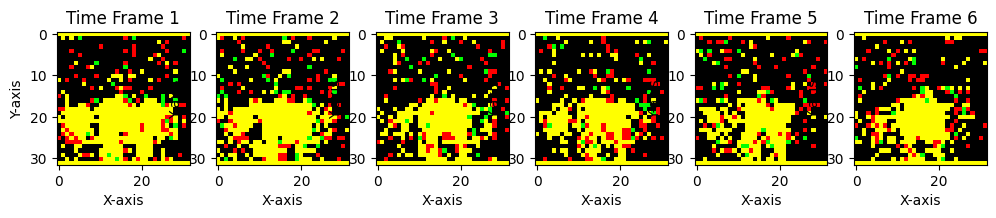

In [41]:
def visualiz_event(data, T_BIN, target_shape):
    fig, axs = plt.subplots(1, T_BIN, figsize=(12, 8))
    for i, (events) in enumerate(data):

        # Create an array of zeros with shape (1, 128, 128)
        zeros = np.zeros((1, target_shape[0], target_shape[1]))
        concatenated_image = np.concatenate((events, zeros), axis=0)

        axs[i].imshow(np.transpose(concatenated_image, (1, 2, 0)))  # Transpose the dimensions to (H, W, C)

        # Set subplot title and labels
        axs[i].set_title(f'Time Frame {i+1}')
        axs[i].set_xlabel('X-axis')
        axs[i].set_ylabel('Y-axis')

    # Show the plot
    plt.show()

T_BIN = 60
visualiz_event(adv_img.to('cpu').squeeze(1),T_BIN-54,(32,32))